# Predicting Stock Prices. Capstone Project.  WORKFLOW


## Uploading dataset as CSV file


In [1]:
# we begin by importing all the necessery packages
import pandas as pd
import numpy as np
import keras
import matplotlib as plt

Using TensorFlow backend.
/Users/diasirish/anaconda3/envs/investment/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/diasirish/anaconda3/envs/investment/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/diasirish/anaconda3/envs/investment/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
from alpha_vantage.timeseries import TimeSeries
from pprint import pprint


def load_dataset(index_symbol, data_time_format):
    api_key = 'CE3D7I5S0BCP8IGM'
    print('... searching for: ', index_symbol, data_time_format)
    ts = TimeSeries(key=api_key, output_format='pandas')
    if data_time_format == 'intraday':
        data, meta_data = ts.get_intraday(
            index_symbol, interval='1min', outputsize='full')   
    elif data_time_format == 'daily':
        data, meta_data = ts.get_daily(index_symbol, outputsize='full')
    elif data_time_format == 'daily_adj':
        data, meta_data = ts.get_daily_adjusted(index_symbol, outputsize='full')

    data.to_csv(f'./{index_symbol}_{data_time_format}.csv')
    
    print('--> requested data is found and downloaded:' )
    pprint(data.head(10))



In [116]:
load_dataset('GOOG','daily')

... searching for:  GOOG daily
--> requested data is found and downloaded:
            1. open  2. high   3. low  4. close  5. volume
date                                                      
2020-03-09  1205.30  1241.40  1200.00   1229.61   837138.0
2020-03-06  1277.06  1306.22  1261.05   1298.41  2660628.0
2020-03-05  1350.20  1358.91  1305.10   1319.04  2561288.0
2020-03-04  1359.23  1388.09  1343.11   1386.52  1913315.0
2020-03-03  1399.42  1410.15  1332.00   1341.39  2402326.0
2020-03-02  1351.61  1390.87  1326.82   1389.11  2431468.0
2020-02-28  1277.50  1341.14  1271.00   1339.33  3790618.0
2020-02-27  1362.06  1371.70  1317.17   1318.09  2978300.0
2020-02-26  1396.14  1415.70  1379.00   1393.18  2204037.0
2020-02-25  1433.00  1438.14  1382.40   1388.45  2478278.0


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 

In [4]:
import pandas as pd
from sklearn import preprocessing
import numpy as np

In [5]:
history_points = 50
n_features = 5

In [117]:
# load dataset
stock_data = pd.read_csv('GOOG_daily.csv', header=0, index_col=0)
values = stock_data.values

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, history_points, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-4,-3,-2,-1]], axis=1, inplace=True)
print(reframed.head())

    var1(t-50)  var2(t-50)  var3(t-50)  var4(t-50)  var5(t-50)  var1(t-49)  \
50    0.689670    0.719428    0.689120    0.712728    0.074324    0.759312   
51    0.759312    0.781988    0.748172    0.779256    0.237763    0.830292   
52    0.830292    0.832840    0.790780    0.799205    0.228859    0.839056   
53    0.839056    0.861002    0.827546    0.864458    0.170781    0.878060   
54    0.878060    0.882293    0.816799    0.820817    0.214611    0.831661   

    var2(t-49)  var3(t-49)  var4(t-49)  var5(t-49)  ...  var2(t-2)  var3(t-2)  \
50    0.781988    0.748172    0.779256    0.237763  ...   0.838264   0.833543   
51    0.832840    0.790780    0.799205    0.228859  ...   0.835176   0.828861   
52    0.861002    0.827546    0.864458    0.170781  ...   0.824492   0.827227   
53    0.882293    0.816799    0.820817    0.214611  ...   0.833699   0.830834   
54    0.863685    0.811789    0.866962    0.217223  ...   0.837405   0.833243   

    var4(t-2)  var5(t-2)  var1(t-1)  var2(t-

In [118]:
reframed.shape

(1448, 251)

In [119]:
# split into train and test sets
values = reframed.values

# another way to split the data:
test_split = 0.9
n = int(values.shape[0] * test_split)
n_obs = history_points * n_features

stock_data_train, stock_data_test = values[:n], values[n:]

train_X, train_y = stock_data_train[:, :n_obs], stock_data_train[:, -n_features]
test_X, test_y = stock_data_test[:, :n_obs], stock_data_test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], history_points, n_features))
test_X = test_X.reshape((test_X.shape[0], history_points, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1303, 250) 1303 (1303,)
(1303, 50, 5) (1303,) (145, 50, 5) (145,)


## Creating LSTM model

In [120]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation
from keras import optimizers
import numpy as np
from tensorflow import set_random_seed

Train on 1303 samples, validate on 145 samples
Epoch 1/50
 - 1s - loss: 0.2553 - val_loss: 0.0855
Epoch 2/50
 - 1s - loss: 0.0244 - val_loss: 0.0130
Epoch 3/50
 - 1s - loss: 0.0455 - val_loss: 0.0141
Epoch 4/50
 - 1s - loss: 0.0344 - val_loss: 0.0147
Epoch 5/50
 - 1s - loss: 0.0197 - val_loss: 0.0084
Epoch 6/50
 - 1s - loss: 0.0211 - val_loss: 0.0080
Epoch 7/50
 - 1s - loss: 0.0205 - val_loss: 0.0079
Epoch 8/50
 - 1s - loss: 0.0201 - val_loss: 0.0077
Epoch 9/50
 - 1s - loss: 0.0139 - val_loss: 0.0077
Epoch 10/50
 - 1s - loss: 0.0116 - val_loss: 0.0083
Epoch 11/50
 - 1s - loss: 0.0268 - val_loss: 0.0117
Epoch 12/50
 - 1s - loss: 0.0140 - val_loss: 0.0079
Epoch 13/50
 - 1s - loss: 0.0207 - val_loss: 0.0075
Epoch 14/50
 - 1s - loss: 0.0129 - val_loss: 0.0079
Epoch 15/50
 - 1s - loss: 0.0228 - val_loss: 0.0086
Epoch 16/50
 - 1s - loss: 0.0102 - val_loss: 0.0074
Epoch 17/50
 - 1s - loss: 0.0162 - val_loss: 0.0069
Epoch 18/50
 - 1s - loss: 0.0114 - val_loss: 0.0082
Epoch 19/50
 - 1s - loss: 

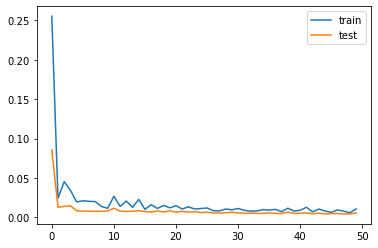

In [121]:

# design network
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mae', optimizer='adam')
# fit network
history = lstm_model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

from matplotlib import pyplot

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [122]:
train_X.shape[1], train_X.shape[2]

(50, 5)

In [123]:
print(lstm_model.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 50)                11200     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
None


In [124]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = lstm_model.predict(test_X)
print(yhat.shape)


LSTM_test_X = test_X.reshape((test_X.shape[0], history_points* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, LSTM_test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, LSTM_test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(145, 1)
Test RMSE: 7.502


In [125]:
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.502


In [126]:
from sklearn.metrics import r2_score
LSTM_r_squared = r2_score(inv_y,inv_yhat)
LSTM_r_squared

0.8868418570313508

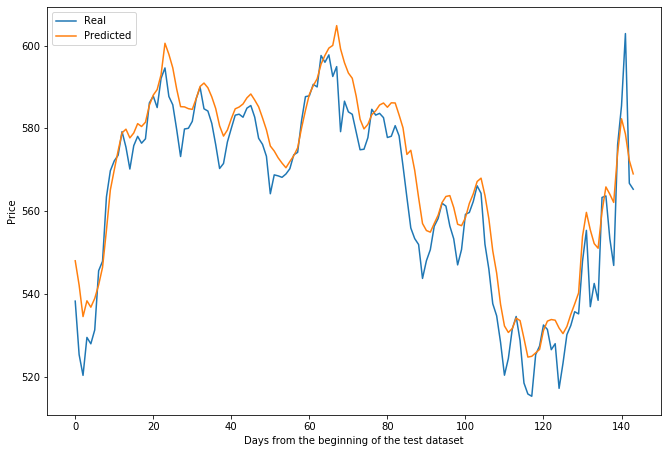

In [127]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(11, 7.5, forward=True)

start = 0
end = -1

real = plt.plot(inv_y[start:end], label='real')
pred = plt.plot(inv_yhat[start:end], label='predicted')

#plt.gca().invert_xaxis()


# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.ylabel('Price')
plt.xlabel('Days from the beginning of the test dataset')


plt.show()

## Second LSTM model

Train on 1303 samples, validate on 145 samples
Epoch 1/50
 - 2s - loss: 1.2405 - val_loss: 0.2194
Epoch 2/50
 - 1s - loss: 0.1647 - val_loss: 0.1063
Epoch 3/50
 - 1s - loss: 0.3253 - val_loss: 0.1888
Epoch 4/50
 - 1s - loss: 0.1827 - val_loss: 0.0451
Epoch 5/50
 - 1s - loss: 0.1672 - val_loss: 0.0489
Epoch 6/50
 - 1s - loss: 0.0887 - val_loss: 0.0719
Epoch 7/50
 - 1s - loss: 0.1285 - val_loss: 0.0845
Epoch 8/50
 - 1s - loss: 0.1450 - val_loss: 0.0404
Epoch 9/50
 - 1s - loss: 0.0832 - val_loss: 0.0390
Epoch 10/50
 - 1s - loss: 0.0546 - val_loss: 0.0071
Epoch 11/50
 - 1s - loss: 0.0744 - val_loss: 0.0483
Epoch 12/50
 - 1s - loss: 0.1332 - val_loss: 0.0330
Epoch 13/50
 - 1s - loss: 0.0882 - val_loss: 0.0295
Epoch 14/50
 - 1s - loss: 0.0513 - val_loss: 0.0071
Epoch 15/50
 - 1s - loss: 0.0427 - val_loss: 0.0077
Epoch 16/50
 - 1s - loss: 0.0386 - val_loss: 0.0097
Epoch 17/50
 - 1s - loss: 0.0455 - val_loss: 0.0075
Epoch 18/50
 - 1s - loss: 0.0394 - val_loss: 0.0119
Epoch 19/50
 - 1s - loss: 

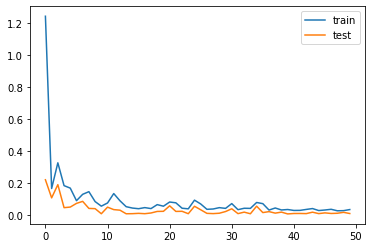

In [128]:
from keras.layers import Activation, Dropout
# design network
lstm_model_2 = Sequential()
lstm_model_2.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
lstm_model_2.add(Dropout(0.2))
lstm_model_2.add(Dense(64))
lstm_model_2.add(Activation('sigmoid'))
lstm_model_2.add(Dense(1))
lstm_model_2.compile(loss='mae', optimizer='adam')
# fit network
history = lstm_model_2.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

from matplotlib import pyplot

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [129]:
print(lstm_model_2.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 50)                11200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                3264      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 14,529
Trainable params: 14,529
Non-trainable params: 0
_________________________________________________________________
None


In [130]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = lstm_model_2.predict(test_X)
print(yhat.shape)


LSTM_test_X = test_X.reshape((test_X.shape[0], history_points* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, LSTM_test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, LSTM_test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(145, 1)
Test RMSE: 12.456


In [131]:
from sklearn.metrics import r2_score
LSTM_r_squared = r2_score(inv_y,inv_yhat)
LSTM_r_squared

0.6880276871211299

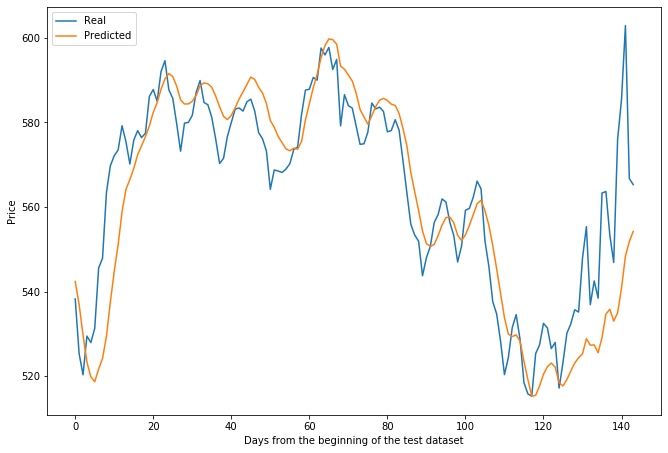

In [132]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(11, 7.5, forward=True)

start = 0
end = -1

real = plt.plot(inv_y[start:end], label='real')
pred = plt.plot(inv_yhat[start:end], label='predicted')

#plt.gca().invert_xaxis()


# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.ylabel('Price')
plt.xlabel('Days from the beginning of the test dataset')


plt.show()

## Third LSTM model

Train on 1303 samples, validate on 145 samples
Epoch 1/50
1303/1303 [==============================] - 3s 2ms/step - loss: 0.1622 - val_loss: 0.0191
Epoch 2/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0812 - val_loss: 0.0180
Epoch 3/50
1303/1303 [==============================] - 2s 1ms/step - loss: 0.0318 - val_loss: 0.0104
Epoch 4/50
1303/1303 [==============================] - 2s 1ms/step - loss: 0.0225 - val_loss: 0.0098
Epoch 5/50
1303/1303 [==============================] - 2s 1ms/step - loss: 0.0212 - val_loss: 0.0087
Epoch 6/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0153 - val_loss: 0.0082
Epoch 7/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0145 - val_loss: 0.0079
Epoch 8/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0164 - val_loss: 0.0080
Epoch 9/50
1303/1303 [==============================] - 2s 2ms/step - loss: 0.0138 - val_loss: 0.0078
Epoch 10/50
1303/1303 [============

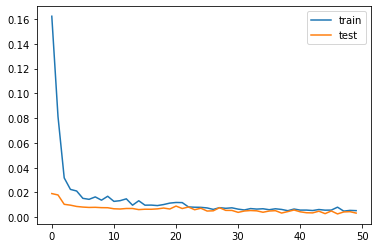

In [133]:
from keras.layers import Activation, Dropout
# design network
lstm_model_3 = Sequential()
lstm_model_3.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
lstm_model_3.add(Dense(1))
lstm_model_3.compile(loss='mae', optimizer='adam')
# fit network
history = lstm_model_3.fit(train_X, train_y, epochs=50, batch_size=22, validation_data=(test_X, test_y), verbose=1, shuffle=False)

from matplotlib import pyplot

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [134]:
print(lstm_model_3.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50)                11200     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
None


In [135]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = lstm_model_3.predict(test_X)
print(yhat.shape)


LSTM_test_X = test_X.reshape((test_X.shape[0], history_points* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, LSTM_test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, LSTM_test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

(145, 1)
Test RMSE: 4.752


In [136]:
from sklearn.metrics import r2_score
LSTM_r_squared = r2_score(inv_y,inv_yhat)
LSTM_r_squared

0.954592566617532

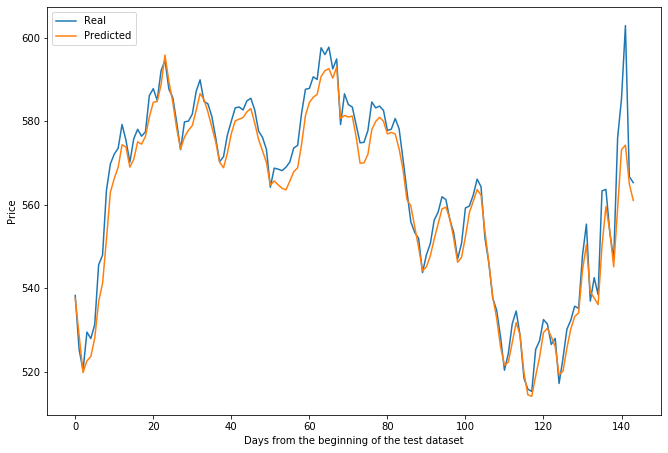

In [137]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(11, 7.5, forward=True)

start = 0
end = -1

real = plt.plot(inv_y[start:end], label='real')
pred = plt.plot(inv_yhat[start:end], label='predicted')

#plt.gca().invert_xaxis()


# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.ylabel('Price')
plt.xlabel('Days from the beginning of the test dataset')


plt.show()

## Creating base model

In [142]:
from sklearn.linear_model import LinearRegression

In [143]:
train_X[:,:,0].shape

(1303, 50)

In [144]:
train_y.shape

(1303,)

In [145]:
test_X.shape

(145, 50, 5)

In [146]:
regression_train_X = train_X[:,:,0]
regression_test_X = test_X[:,:,0]

In [147]:
linear_regressor = LinearRegression()  
linear_regressor.fit(regression_train_X, train_y)


y_test_hat_regression = linear_regressor.predict(regression_test_X)
#y_test_hat_regression = scaler.inverse_transform(y_test_hat_regression)
y_test_hat_regression = y_test_hat_regression.reshape((len(y_test_hat_regression),1))
print(y_test_hat_regression.shape)
                                                      
# invert scaling for forecast
inv_yhat = np.concatenate((y_test_hat_regression, LSTM_test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, LSTM_test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

(145, 1)


In [148]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 4.122


In [149]:
from sklearn.metrics import r2_score
regression_r_squared = r2_score(inv_y,inv_yhat)
regression_r_squared

0.9658301395936177

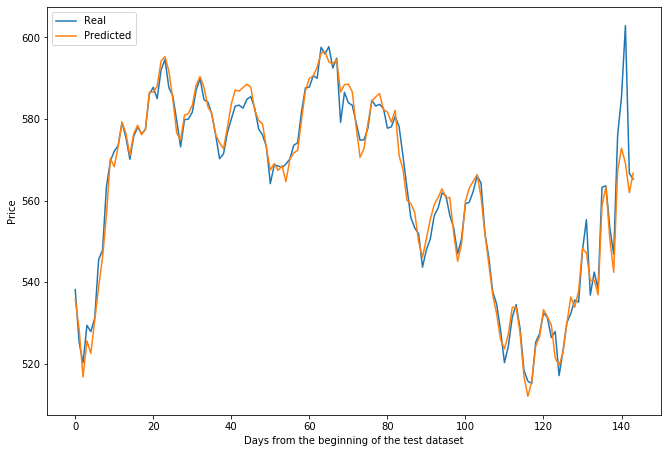

In [150]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(11, 7.5, forward=True)

start = 0
end = -1

#plt.gca().invert_xaxis()
real = plt.plot(inv_y[start:end], label='real')
pred = plt.plot(inv_yhat[start:end], label='predicted')

# real = plt.plot(unscaled_y[start:end], label='real')
# pred = plt.plot(y_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])
plt.ylabel('Price')
plt.xlabel('Days from the beginning of the test dataset')



plt.show()

## Manual k-Fold Cross Validation

In [140]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
X = np.append(train_X , test_X)
y = np.append(train_y, test_y)
print(X.shape,y.shape)
X = X.reshape((1448, 50, 5))


(1303, 50, 5) (1303,) (145, 50, 5) (145, 1)
(362000,) (1448,)


In [152]:
# using this algorithm to crea K fold sensitivity test for our model
#from keras.models import Sequential
#from keras.layers import Dense
#from sklearn.model_selection import StratifiedKFold
#import numpy
# fix random seed for reproducibility
#seed = 7
#numpy.random.seed(seed)


#X = np.append(train_X , test_X)
#X = X.reshape((1448, 50, 5))

#y = np.append(train_y, test_y)

# define 10-fold cross validation test harness
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
#cvscores = []
#for train, test in kfold.split(X, y):
    # design network
    #lstm_model_3 = Sequential()
    #lstm_model_3.add(LSTM(50, input_shape=(train.shape[1], train.shape[2])))
    #lstm_model_3.add(Dense(1))
    #lstm_model_3.compile(loss='mae', optimizer='adam')
    # fit network
    #history = lstm_model_3.fit(train_X, train_y, epochs=50, batch_size=22, validation_data=(test_X, test_y), verbose=1, shuffle=False)
    # Fit the model
    #lstm_model_3.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    #scores = lstm_model_3.evaluate(X[test], Y[test], verbose=0)
    #print("%s: %.2f%%" % (lstm_model_3.metrics_names[1], scores[1]*100))
    #cvscores.append(scores[1] * 100)
#print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))